In [7]:
import numpy as np
import pytz
import datetime
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

PST_TZ = pytz.timezone('America/Los_Angeles')

GOHAWKS = "tweet_data/tweets_#gohawks.txt"
GOPATRIOTS = "tweet_data/tweets_#gopatriots.txt"
NFL = "tweet_data/tweets_#nfl.txt"
PATRIOTS = "tweet_data/tweets_#patriots.txt"
SB49 = "tweet_data/tweets_#sb49.txt"
SUPERBOWL = "tweet_data/tweets_#superbowl.txt"
ALL_FILES = [GOHAWKS, GOPATRIOTS, NFL, PATRIOTS, SB49, SUPERBOWL]
ALL_HASHTAGS = ["#gohawks", "#gopatriots", "#nfl", "#patriots", "#sb49", "#superbowl"]

In [47]:
# def GetJSONData(filepath):
#     with open(filepath, encoding="utf8") as fp:
#         data = [json.loads(line) for line in fp]
#     return data
    
def GetTweetStats(filepath):
    followers = 0
    retweets = 0
    data_len = 0
    count = 1
    res = []
    first_tweet = True
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            tweet = json.loads(line)
            followers += tweet['author']['followers']
            retweets += tweet['metrics']['citations']['total']
            data_len += 1
            if first_tweet:
                first_time = tweet['firstpost_date']
                first_datetime = datetime.datetime.fromtimestamp(first_time)
                next_time = first_datetime + datetime.timedelta(hours=1)
                first_tweet = False
            else:
                last_time = tweet['firstpost_date']
                last_datetime = datetime.datetime.fromtimestamp(last_time)
                if last_datetime > next_time:
                    while last_datetime >= next_time:
                        next_time = next_time + datetime.timedelta(hours=1)
                        res.append(count)
                        count = 0
                    count = 1
                else:
                    count += 1
    
    res.append(count)
    followers /= float(data_len)
    retweets /= float(data_len)
    
    time_diff = last_datetime - first_datetime
    num_hours = divmod(time_diff.total_seconds(), 3600)[0]
    tweets_per_hour = float(data_len) / num_hours
    
    return tweets_per_hour, followers, retweets, res

In [48]:
nfl_counts = []
superbowl_counts = []
for file, hashtag in zip(ALL_FILES, ALL_HASHTAGS):
    stats = GetTweetStats(file)
    print("Statisics for", hashtag)
    print("Average tweets per hour:", stats[0])
    print("Average followers per tweet:", stats[1])
    print("Average retweets per tweet:", stats[2])
    print()
    if hashtag == "nfl":
        nfl_counts = stats[3]
    elif hashtag == "superbowl":
        superbowl_counts = stats[3]

Statisics for gohawks
Average tweets per hour: 173.99382716049382
Average followers per tweet: 2217.9237355281984
Average retweets per tweet: 2.0132093991319877
Statisics for gopatriots
Average tweets per hour: 34.42313323572474
Average followers per tweet: 1427.2526051635405
Average retweets per tweet: 1.4081919101697078
Statisics for nfl
Average tweets per hour: 251.64362850971924
Average followers per tweet: 4662.37544523693
Average retweets per tweet: 1.5344602655543254
Statisics for patriots
Average tweets per hour: 449.61326530612246
Average followers per tweet: 3280.4635616550277
Average retweets per tweet: 1.7852871288476946
Statisics for sb49
Average tweets per hour: 1277.7474226804125
Average followers per tweet: 10374.160292019487
Average retweets per tweet: 2.52713444111402
Statisics for superbowl
Average tweets per hour: 1268.3521421107628
Average followers per tweet: 8814.96799424623
Average retweets per tweet: 2.3911895819207736


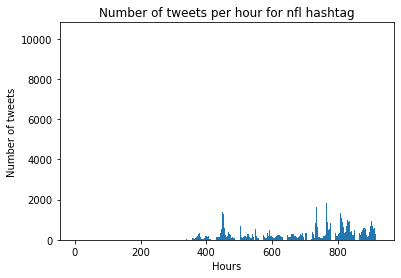

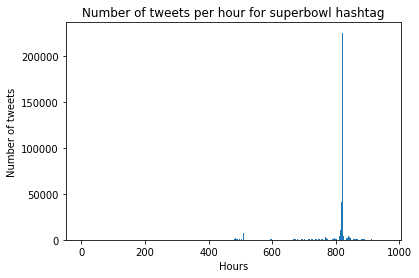

In [49]:
plt.bar(range(len(nfl_counts)), nfl_counts)
plt.title("Number of tweets per hour for nfl hashtag")
plt.xlabel("Hours")
plt.ylabel("Number of tweets")
plt.show()
plt.bar(range(len(superbowl_counts)), superbowl_counts)
plt.title("Number of tweets per hour for superbowl hashtag")
plt.xlabel("Hours")
plt.ylabel("Number of tweets")
plt.show()

In [4]:
def UpdateFeature(feature, tweet, cur_datetime):
    feature[0] += 1 # number of tweets in window
    feature[1] += tweet['metrics']['citations']['total'] # number of retweets
    feature[2] += tweet['author']['followers'] # number of followers
    feature[3] = max(feature[3], tweet['author']['followers']) # max number of followers per post
    feature[4] = cur_datetime.hour # hour of the day
    return feature

def GetDataTargets(data):
    targets = []
    for idx in range(len(data)-1):
        targets.append(data[idx+1][0])
    targets.append(0)
    return targets
    
def GetDataFeatures(filepath):
    data = []
    cur_feature = np.zeros(5)
    first_tweet = True
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            tweet = json.loads(line)
            cur_time = tweet['firstpost_date']
            cur_datetime = datetime.datetime.fromtimestamp(cur_time, PST_TZ)
            if first_tweet:
                if cur_datetime.hour < 23:
                    end_time = cur_datetime.replace(second=0, microsecond=0, minute=0, hour=cur_datetime.hour+1)
                else:
                    end_time = cur_datetime.replace(second=0, microsecond=0, minute=0, hour=0, day=cur_datetime.day+1)
                cur_feature = UpdateFeature(cur_feature, tweet, cur_datetime)
                first_tweet = False
            else:
                if cur_datetime < end_time:
                    cur_feature = UpdateFeature(cur_feature, tweet, cur_datetime)
                else:
                    while cur_datetime >= end_time:
                        end_time += datetime.timedelta(hours=1)
                        data.append(cur_feature)
                        cur_feature = np.zeros(5)
                    cur_feature = UpdateFeature(cur_feature, tweet, cur_datetime)
    data.append(cur_feature)
    targets = GetDataTargets(data)
    return np.array(data), np.array(targets)

In [24]:
def ScoreOLS(data, targets):
    data = sm.add_constant(data)
    model = sm.OLS(targets, data)
    results = model.fit()
    
    preds = results.predict(data)
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)

    print("mse:", mse)
    print("r2:", r2)
    print("tvalues:", results.tvalues)
    print("pvalues:", results.pvalues)

In [25]:
for file, hashtag in zip(ALL_FILES, ALL_HASHTAGS):
    data, targets = GetDataFeatures(file)
    print("Results for", hashtag)
    print("data shape:", data.shape)
    ScoreOLS(data, targets)
    print()

Results for gohawks
data shape: (973, 5)
mse: 453578.7486139947
r2: 0.48590927617552493
tvalues: [ 1.08077764 10.44064355 -4.07835853 -2.9768586   0.65304     1.37735108]
pvalues: [2.80065503e-01 2.97508596e-24 4.90865442e-05 2.98474171e-03
 5.13885719e-01 1.68722443e-01]

Results for gopatriots
data shape: (684, 5)
mse: 21831.47522865118
r2: 0.653971081911064
tvalues: [ 0.17076797 -1.59989195  8.02088091 -3.604888    2.54022053 -0.18773757]
pvalues: [8.64457165e-01 1.10088401e-01 4.61673254e-15 3.35183637e-04
 1.13002596e-02 8.51138550e-01]

Results for nfl
data shape: (927, 5)
mse: 173049.88794530474
r2: 0.6014683557318541
tvalues: [ 2.01563501  5.58944403 -3.53909633  4.94821016 -3.34897774  2.39503814]
pvalues: [4.41281846e-02 3.00072288e-08 4.21575799e-04 8.90288019e-07
 8.44009171e-04 1.68175348e-02]

Results for patriots
data shape: (981, 5)
mse: 2786511.109114322
r2: 0.7080068674117341
tvalues: [  1.05038766  21.65141621 -12.11920832   6.65463573  -1.31312292
   1.00209429]
pva